# Introduction to the human metabolic reconstruction and FBA and FVA

**Authors**: Thierry D.G.A Mondeel, Stefania Astrologo, Ewelina Weglarz-Tomczak & Hans V. Westerhoff <br/>
University of Amsterdam <br/>
2016 - 2018

**Note:** Some of the material in this tutorial is inspired by and adapted from the cell factory design course from The Novo Nordisk Foundation Center for Biosustainability https://biosustain.github.io/cell-factory-design-course/

**Questions**
- How do I explore the content (metabolites, reactions, genes, …) of the human metabolic reconstruction?
- How do I perform flux balance analysis?
- What kind of questions can I answer by performing FBA experiments?
- What is FVA and what can I use it for?

**Objectives**
- Understand the basic data structures of models.
- Set a biological objective and simulate a model with FBA.
- Manipulate bounds for defining media conditions and knocking out reactions/genes
- Find essential reactions with FVA

## Refresher: the human metabolic reconstruction: Recon 2 and Recon 3D

See the publication: [Recon 2 (2012)](http://doi.org/10.1038/nbt.2488) and [Recon 3D (2018)](https://www.nature.com/articles/nbt.4072).

<span style="color:red">**Assignment (5 min):**</span> Read the abstract of the 2012 publication and the first paragraph of the introduction.

## Loading the human metabolic map
<span style="color:red">**Assignment (1 sec):**</span> Execute the cell below.

This cell loads the COBRA python module and load the human metabolic reconstruction. The specifics of the code do not matter.

In [2]:
import cobra
from cobra.flux_analysis import pfba
import pandas as pd # for tables
pd.set_option('display.max_colwidth', -1) # don't constrain the content of the tables
pd.options.display.max_rows = 9999

from utils import show_map
import escher
map_loc = './maps/escher_map_RECON3D_energy_metabolism.json' # the escher map used below

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

M = cobra.io.load_json_model('models/Recon3D_301/Recon3DModel_301_simple_medium.json')
model = M.copy() # this way we can edit model but leave M unaltered

# What is a metabolic reconstruction really?
Above we loaded the human metabolic reconstruction. An easy way to think about such reconstructions is that they are maps, very much like road maps such as: [Google Maps](http://maps.google.com).

You can think of this biological map as having three key components:
1. Metabolites
    > Places you want to go 
2. Reactions
    > Roads that connect where you are to where you want to go
3. Reactions are coupled to gene(s) that encode the enzyme catalyzing the reaction.
    > Do I need a car to take this road? Or a bike? Or either?

We can interact with the map through 3 different kinds of object: metabolites, reactions and genes. We will look at these below.

## Accessing the contents of the map: metabolites, reactions and genes
The model for the human metabolic network contains many different genes, reactions and metabolites.

> You can access each of these three sets (genes, reactions and metabolites) through 'dot' notation: 
>
> e.g. model.genes

<span style="color:red">**Assignment (5 min):**</span> Find out how many genes, reactions and metabolites the map contains. **Tip:** use the len() function and use the dot notation (e.g. model.genes) shown above.

In [3]:
# calculate the number of genes here

# calculate the number of reactions here

# calculate the number of metabolites here


<span style="color:red">**Assignment (2 min):**</span> Why are there so few genes? What about all the other human genes? How many genes do humans actually have in total? 

See the abstract of: http://doi.org/10.1126/science.1058040

### Metabolites

One can access a specific metabolite using dot notation.

> model.metabolites.METABOLITE_ID

<span style="color:red">**Assignment (1 min):**</span>
* Look at the properties of the metabolite ATP, below. 
* Notice the dot notation used to access it

In [4]:
model.metabolites.atp_c

Metabolite identifier,atp_c
Name,Adenosine Triphosphate
Memory address,0x011ddb75f8
Formula,C10H12N5O13P3
Compartment,c
In 743 reaction(s),"XOL7AONEATP, XOLDIOLONEATP, ACCOAL, XOL7AH3ATP, 7KILTCHOLATP, THCHOLSTOICATP, DHCHOLESTANATEATP, HKt, GTACMPtev, C04717ATP, R_group_phosphotase_2, C04483t1, C04805ATP, R_group_phosphotase_3, ATPtg,..."


**Warning:** One cannot use dot notation to access metabolites, reactions, or genes if their identifiers do not resemble proper Python variable names.

In [5]:
model.metabolites.10fthf_c

SyntaxError: invalid syntax (<ipython-input-5-2d9f6c5b57e5>, line 1)

**Solution:** Use the method `get_by_id` instead!


In [6]:
model.metabolites.get_by_id('10fthf_c')

Metabolite identifier,10fthf_c
Name,10-Formyltetrahydrofolate
Memory address,0x011dda3dd8
Formula,C20H21N7O7
Compartment,c
In 8 reaction(s),"FPGS7, AICART, MTHFC, GARFT, FTHFDH, FTHFL, 10FTHFtl, 10FTHFtm"


#### Finding metabolites
If you are not sure which ID the metabolite you are looking has, you can use a query to look for it. Suppose we want to find lactate:

In [7]:
model.metabolites.query('lactate','name')

[<Metabolite mercplaccys_e at 0x11e6a8128>,
 <Metabolite sl_L_e at 0x11e869668>,
 <Metabolite mercplaccys_c at 0x1221a1860>,
 <Metabolite mercplac_c at 0x1221a1588>,
 <Metabolite sl_L_c at 0x12216a278>,
 <Metabolite phlac_c at 0x1220578d0>,
 <Metabolite phlac_e at 0x12203b208>]

The above doesn't look very user friendly. Let's build a nice table to view these metabolites.

In [8]:
df = pd.DataFrame(columns=['ID',"Name","Compartment","Formula"]) # start empty table

for i, metabolite in enumerate(model.metabolites.query('lactate','name')):
    df.loc[i] = [metabolite.id, metabolite.name, metabolite.compartment, metabolite.formula]

df

,ID,Name,Compartment,Formula
0,mercplaccys_e,3-Mercaptolactate-Cysteine Disulfide,e,C6H10O5S2N
1,sl_L_e,(S)-3-Sulfonatolactate,e,C3H4O6S
2,mercplaccys_c,3-Mercaptolactate-Cysteine Disulfide,c,C6H10O5S2N
3,mercplac_c,3-Mercaptolactate,c,C3H5O3S
4,sl_L_c,(S)-3-Sulfonatolactate,c,C3H4O6S
5,phlac_c,Phenyllactate,c,C9H9O3
6,phlac_e,Phenyllactate,e,C9H9O3


<span style="color:red">**Assignment (3 min):**</span> 
* Search for another metabolite of your interest and look at its properties. 
* To start, copy the code from the cell above and modify the search term

#### Properties of metabolites
Metabolites are associated with compartments in the cell. Glyceraldehyde 3-phosphate (g3p_c) is associated with the c (Cytosol) compartment.


In [9]:
model.metabolites.g3p_c.compartment

'c'

The metabolites in the human metabolic reconstruction are categorized in various compartments. 

In [10]:
model.compartments.keys()

dict_keys(['c', 'l', 'm', 'r', 'e', 'x', 'n', 'g', 'i'])

<span style="color:red">**Assignment (3 min):**</span> Can you identify which compartments the identifiers point to? Do you know the biological role of all these compartments?

See here for more information: http://www.ncbi.nlm.nih.gov/books/NBK26907/

<span style="color:red">**Assignment (3 min):**</span> Some metabolites (like Glucose for example) can be associated with multiple compartments. Do they participate in the same reactions? 

In [11]:
model.metabolites.glc_D_c
model.metabolites.glc_D_g

Metabolite identifier,glc_D_c
Name,D-Glucose
Memory address,0x011df46b00
Formula,C6H12O6
Compartment,c
In 20 reaction(s),"r1392, HMR_8884, r0354, MLTG1, r0355, HEX1, TREH, GLCt2_2, GLCter, GBA, SBTR, GLCtg, GLCSGLT1le, GLDBRAN, GLCtly, GLCt1r, MALT, GLPASE2, RE1342C, GLCt4"


Metabolite identifier,glc_D_g
Name,D-Glucose
Memory address,0x01221e2518
Formula,C6H12O6
Compartment,g
In 2 reaction(s),"UGALGTg, GLCtg"


The full name of the metabolite is available via the .name attribute.

In [12]:
model.metabolites.glc_D_c.name

'D-Glucose'

One can look up the molecular formula of glucose and its weight.

The .elements attribute returns a dictionary representation of the formula.

In [13]:
model.metabolites.glc_D_c.formula
model.metabolites.glc_D_c.formula_weight
model.metabolites.glc_D_c.elements

'C6H12O6'

180.15588

{'C': 6, 'H': 12, 'O': 6}

### Reactions

Metabolites are not isolated things. They participate in reactions as substrates and products.



Reactions have similar properties as metabolites. Below we show pyruvate kinase, like we showed ATP before.

**Note:** metabolites identifiers are usually lowercase, whereas reaction identifiers are usually uppercase.

In [14]:
model.reactions.PYK

Reaction identifier,PYK
Name,Pyruvate Kinase
Memory address,0x0121383f98
Stoichiometry,adp_c + h_c + pep_c --> atp_c + pyr_c Adenosine Diphosphate + Proton + Phosphoenolpyruvate --> Adenosine Triphosphate + Pyruvate
GPR,5315.2 or 5313.2 or 5315.3 or 5313.1 or 5315.1
Lower bound,0.0
Upper bound,1000.0


Let's take a closer look at the reactions associated with Glyceraldehyde 3-phosphate (g3p). Reactions like metabolites have both a short ID, a longer name attribute and an attribute called reaction that contains the chemical reaction equation. Lets see all of these for the reactions g3p engages in.

In [15]:
df = pd.DataFrame(columns=['ID',"Name",'Reaction','Subsystem']) # start empty table

# add each reaction to the table
for i, reaction in enumerate(model.metabolites.g3p_c.reactions):
    df.loc[i] = [reaction.id,reaction.name, reaction.reaction, reaction.subsystem]
df

,ID,Name,Reaction,Subsystem
0,TKT1,Transketolase,r5p_c + xu5p_D_c <=> g3p_c + s7p_c,[Pentose phosphate pathway]
1,TRIOK,Triokinase,atp_c + glyald_c --> adp_c + g3p_c + h_c,[Fructose and mannose metabolism]
2,TKT2,Transketolase,e4p_c + xu5p_D_c <=> f6p_c + g3p_c,[Pentose phosphate pathway]
3,TPI,Triose-Phosphate Isomerase,dhap_c <=> g3p_c,[Glycolysis/gluconeogenesis]
4,GAPD,Glyceraldehyde-3-Phosphate Dehydrogenase,g3p_c + nad_c + pi_c <=> 13dpg_c + h_c + nadh_c,[Glycolysis/gluconeogenesis]
5,TALA,Transaldolase,g3p_c + s7p_c <=> e4p_c + f6p_c,[Pentose phosphate pathway]
6,FBA,Fructose-Bisphosphate Aldolase,fdp_c <=> dhap_c + g3p_c,[Glycolysis/gluconeogenesis]
7,DRPA,Deoxyribose-Phosphate Aldolase,2dr5p_c --> acald_c + g3p_c,[Pentose phosphate pathway]
8,MGSA2,Methyglyoxylate Synthase 2 (from G3P),g3p_c --> mthgxl_c + pi_c,[Pyruvate metabolism]


#### Reaction bounds
In constraint-based (FBA) models reactions are associated with two bounds, a lower bound and an upper bound. These constrain the amount of flux that is allowed to run through a certain reaction. 

The most important way these are used is to take into account thermodynamics of reactions. If a certain reaction has a very high **negative** $\Delta G^{'0}$ then this reaction is practically irreversible. As such its lower bound is often made zero, meaning that the flux cannot run in the backward direction because it goes against thermodynamics. This makes the model predictions more realistic.

##### If you need a refresher on thermodynamics 
This page has all you need to know: https://www.khanacademy.org/science/chemistry/thermodynamics-chemistry/gibbs-free-energy/a/gibbs-free-energy-and-spontaneity

Let's look at an example: pyruvate kinase has a lower bound of zero in our model.

In [16]:
model.reactions.PYK.name
model.reactions.PYK.reaction
model.reactions.PYK.bounds

'Pyruvate Kinase'

'adp_c + h_c + pep_c --> atp_c + pyr_c'

(0.0, 1000.0)

<span style="color:red">**Assignment (3 min):**</span> Check that this makes sense thermodynamically. Go to: http://equilibrator.weizmann.ac.il/ and type in "pyruvate kinase". Click the reaction corresponding to the one above.

Look at the estimates for the $\Delta G^{'0}$. Does this match with the model? 

### Genes and their link to reactions
Remember that the core of the model is made up of reactions that link together metabolites. The second layer of the model consists of genes coupling to reactions. 

Glyceraldehyde-3-phosphate dehydrogenase is associated with two genes.

In [17]:
model.reactions.GAPD.gene_reaction_rule

'2597.1 or 26330.1'

These gene identifiers refer to the NCBI database: https://www.ncbi.nlm.nih.gov/gene/?term=2597

<span style="color:red">**Assignment (3 min):**</span> Is this annotated correctly. Why two genes?

An example of a more complicated gene to reaction mapping is given by the ATP synthase which has many different components:

In [18]:
model.reactions.ATPS4mi.name
model.reactions.ATPS4mi.reaction
model.reactions.ATPS4mi.gene_reaction_rule

'ATP synthase (four protons for one ATP)'

'adp_m + 4.0 h_i + pi_m --> atp_m + h2o_m + 3.0 h_m'

'((513.1 and 498.2 and 506.1 and 509.2 and 514.1) or (498.2 and 513.2 and 514.2 and 506.1 and 509.2) or (513.1 and 509.1 and 498.1 and 514.2 and 506.1) or (498.2 and 513.2 and 506.1 and 509.2 and 514.1) or (513.2 and 498.1 and 514.2 and 506.1 and 509.2) or (513.1 and 498.1 and 506.1 and 509.2 and 514.1) or (513.1 and 498.2 and 514.2 and 506.1 and 509.2) or (513.1 and 498.2 and 509.1 and 506.1 and 514.1) or (498.2 and 509.1 and 513.2 and 506.1 and 514.1) or (513.2 and 498.1 and 506.1 and 509.2 and 514.1) or (513.2 and 514.2 and 506.1 and 509.2 and 498.3) or (513.2 and 506.1 and 509.2 and 498.3 and 514.1) or (513.1 and 509.1 and 506.1 and 498.3 and 514.1) or (509.1 and 513.2 and 514.2 and 506.1 and 498.3) or (513.1 and 498.2 and 509.1 and 514.2 and 506.1) or (513.1 and 498.1 and 514.2 and 506.1 and 509.2) or (513.1 and 509.1 and 498.1 and 506.1 and 514.1) or (513.1 and 506.1 and 509.2 and 498.3 and 514.1) or (509.1 and 513.2 and 506.1 and 498.3 and 514.1) or (513.1 and 514.2 and 506.1 an

### The medium
The next key component of the model is the "medium", i.e. the set of metabolites that is allowed to be taken up into the cell. For human cells this should entail the essential amino acids, glucose, oxygen etc. The way this is done in the model is by having so-called "exchange reactions" that transport such a metabolite into the extracellular space (the "e" compartment we came across above). Typically each of these reactions start with 'EX_' which stands for exchange reaction. The word exchange refers to the fact that this is an exchange of metabolites with the environment or the biofluids surrounding the cell. 

Exchange reactions are defined as: X <=> . So a negative (to the left) flux means uptake of metabolite X. Positive (to the right) flux would mean X is produced by the cell. This would typically be the case for lactate or CO2 etc. 

<span style="color:red">**Assignment (3 min):**</span> Make sure you understand the difference between an exchange reaction and a transport reaction. They are not the same thing!

Exchange $$X <=> $$ Transport $$ X_c <=> X_e$$

Below we print the medium of the model. The table shows the bound on each such inward flux. The bounds on these fluxes are actually negative but are here shown as positive values. 

In [19]:
pd.DataFrame(list(model.medium.items()),columns=['Reaction','Inward flux']).sort_values('Reaction').set_index('Reaction')

,Inward flux
Reaction,
EX_co2_e,1000.0
EX_glc_D_e,1.0
EX_gln_L_e,0.1
EX_glu_L_e,0.1
EX_h2o_e,1000.0
EX_h_e,1000.0
EX_hco3_e,1000.0
EX_his_L_e,0.1
EX_ile_L_e,0.1


<span style="color:red">**Assignment (3 min):**</span> Would you say this is a reasonable medium for a human cell to live in? What are the limiting medium components currently? Is there an oxygen or carbon limitation? What is/are the carbon source(s)? 

# Performing Flux Balance Analysis

## What is FBA?
We will use the constraint-based modeling technique called flux balance analysis (FBA) (http://doi.org/10.1038/nbt.1614). Given the metabolic network this method computationally calculates the flux distribution, meaning the fluxes through all reactions in the model at steady-state, that is optimal according to a specified objective function. In our case, the objective function will usually be the flux through the biomass reaction. This reaction contains (when known) experimentally determined ratio's of metabolites that make up the composition of a cell.

FBA has traditionally been applied to metabolism as we are doing here. FBA primarily makes use of the stoichiometry matrix $S$. This matrix is of size $m \times r$ where $m$ is the number of species or metabolites in the system and $r$ is the number of reactions. Every row of $S$ specifies for a specific metabolite in what quantity it partakes in each reaction. Therefore, each element $(i,j)$ of $S$ contains the stoichiometric coefficient of metabolite $i$ in reaction $j$.

The word flux is used to describe a reaction rate at steady state. In FBA the aim is to find the flux distributions of the network that satisfy (1) the steady-state condition, this is based on the assumption that metabolism occurs on a fast time-scale compared to gene regulatory events and thus reaction rates are constant, (2) thermodynamic feasibility , i.e. some reactions are known to be irreversible, (3) maximal flux constraints when these are known and (4) maximize some objective like growth. 

### What you will do
We will perform in-silico experiments with genetic manipulations by changing the lower and upper bounds for the reactions. By setting both the lower bound $\alpha_k$ and the upper bound $\beta_k$ to zero we in effect knock out a reaction. Similarly, by setting it to a specific value we can fix a certain flux level for a specific reaction.

### What is our in-silico cell optimizing? 
Let us first check what objective is set for our model.

In [20]:
cobra.util.linear_reaction_coefficients(model)

{<Reaction biomass_reaction at 0x1215f2be0>: 1.0}

So the objective is biomass.

<span style="color:red">**Assignment (5 min):**</span> Is optimal growth a realistic assumption for human cells? For bacterial cells? Discuss... 

### Doing FBA is simple...
Actually performing FBA with cobrapy once you have loaded a model is really easy and fast. 

In [21]:
solution = model.optimize()

"solution" now contains the result of our simulation. Let's see what we can do with this. The most important attributes here are:
- status => did we find an optimial solution?
- objective_value => what is the biomass flux?
- fluxes => the flux through every reaction in the model solution as a dictionary

In [22]:
solution.status
solution.objective_value
solution.fluxes['GAPD']

'optimal'

0.16888639687627707

1.8340552663845209

A very nice summary of what goes in and out of the cell in this solution can be viewed with the summary attribute of the model object.

In [23]:
model.summary()

IN FLUXES        OUT FLUXES      OBJECTIVES
---------------  --------------  ----------------------
o2_e     2.89    h2o_e   4.34    biomass_reac...  0.169
glc_D_e  1       co2_e   2.68
nh4_e    0.28    acac_e  0.617
pi_e     0.163   ppa_e   0.0556
gln_L_e  0.1     so4_e   0.0477
glu_L_e  0.1
his_L_e  0.1
leu_L_e  0.1
lys_L_e  0.1
thr_L_e  0.1
val_L_e  0.1
met_L_e  0.0815
phe_L_e  0.0708
ile_L_e  0.0483
ps_hs_e  0.0463
trp_L_e  0.034
hco3_e   0.0194


<span style="color:red">**Assignment (3 min):**</span> Investigate the metabolites that are produced (i.e. in the OUT FLUXES column). Are these what you would have expected? 

<span style="color:red">**Assignment (3 min):**</span> What would happen if we force the cell to produce lactate (i.e. to ferment)? Try this by setting the **lower_bound** of the exchange reaction of lactate 'EX_lac_D_e' or 'EX_lac_L_e' to a positive number. Lactate is a C3, and we are taking up 1 unit of glucose C6) so set this to a number lower than or equal to 2. Then rerun the cell again. 

What new products have been produced? Did something change in the uptake fluxes? Did the growth rate remain the same? 

In [31]:
model = M.copy()

# change the lactate lower_bound here

solution = model.optimize()
model.summary()

IN FLUXES        OUT FLUXES      OBJECTIVES
---------------  --------------  ----------------------
o2_e     2.89    h2o_e   4.34    biomass_reac...  0.169
glc_D_e  1       co2_e   2.68
nh4_e    0.28    acac_e  0.617
pi_e     0.163   ppa_e   0.0556
gln_L_e  0.1     so4_e   0.0477
glu_L_e  0.1
his_L_e  0.1
leu_L_e  0.1
lys_L_e  0.1
thr_L_e  0.1
val_L_e  0.1
met_L_e  0.0815
phe_L_e  0.0708
ile_L_e  0.0483
ps_hs_e  0.0463
trp_L_e  0.034
hco3_e   0.0194


<span style="color:red">**Assignment (3 min):**</span> Now do something similar but for CO2. CO2 is a C1 compound so try setting the lower bound of its exchange reaction to 6.

In [32]:
model = M.copy()

# Force the CO2 lower_bound here

solution = model.optimize()
model.summary()

IN FLUXES        OUT FLUXES       OBJECTIVES
---------------  ---------------  ----------------------
o2_e     3.24    co2_e    6       biomass_reac...  0.169
hco3_e   2.57    h2o_e    4.84
glc_D_e  1       lac_L_e  0.933
pi_e     0.162   ppa_e    0.0598
nh4_e    0.113
gln_L_e  0.1
glu_L_e  0.1
his_L_e  0.1
ile_L_e  0.1
leu_L_e  0.1
lys_L_e  0.1
phe_L_e  0.1
thr_L_e  0.1
trp_L_e  0.1
val_L_e  0.1
ps_hs_e  0.0477
met_L_e  0.0337


<span style="color:red">**Assignment (5 min):**</span> Above you might have realized that the model can grow optimally virtually only producing CO2 and propionate as a carbon products. You also observed that it grows less than optimally by fermentation alone.

Can you imagine why respiration is optimal here? What could we change about the medium (the environment) to force the model into fermenting? Try something below. 

In [37]:
model = M.copy()

# Don't change this (we want to only allow lactate and CO2 as exits)
model.reactions.EX_bhb_e.upper_bound = 0
model.reactions.EX_acac_e.upper_bound = 0

#### RESTRICT SOMETHING IN THE MEDIUM HERE ####

solution = model.optimize()
model.summary()

IN FLUXES         OUT FLUXES        OBJECTIVES
----------------  ----------------  ----------------------
glc_D_e  1        h_e      1.61     biomass_reac...  0.148
o2_e     0.5      h2o_e    1.03
nh4_e    0.351    lac_D_e  0.985
pi_e     0.143    co2_e    0.542
gln_L_e  0.1      lac_L_e  0.394
glu_L_e  0.1      ppa_e    0.00688
his_L_e  0.1
lys_L_e  0.0875
leu_L_e  0.0806
phe_L_e  0.0619
val_L_e  0.0521
thr_L_e  0.0462
ile_L_e  0.0423
ps_hs_e  0.0405
met_L_e  0.0295
hco3_e   0.017
trp_L_e  0.00197


<span style="color:red">**Hint:**</span> limit oxygen uptake (set a smaller lower_bound on oxygen exchange, e.g. -0.5 and -0.1 and 0)

## How is ATP generated? 
### When maximizing ATPM using only glucose and o2
Below we first remove the amino acids from the medium in order to just ask for ATP production from glucose and oxygen. 

Then we make the ATP maintenance reaction: atp -> adp + pi, the objective reaction. 

<span style="color:red">**Assignment (3 min):**</span> Before running the cell below. Based on your textbook knowledge: what would you expect the maximum number of ATP to be given 1 unit of glucose and unlimited oxygen? 
How much oxygen would be used for this? 

Now execute the cell and compare the results. 

In [39]:
model = M.copy()

# block amino acid uptake
for rxn in ['EX_his_L_e','EX_ile_L_e','EX_leu_L_e','EX_lys_L_e','EX_met_L_e','EX_phe_L_e','EX_thr_L_e','EX_trp_L_e','EX_val_L_e','EX_glu_L_e','EX_gln_L_e']:
    model.reactions.get_by_id(rxn).lower_bound = 0

model.objective = model.reactions.ATPM
solution = model.optimize()

model.summary()
print("\nLet's look at cytosolic ATP production\n")
model.metabolites.atp_c.summary()
print("\nLet's look at mitochondrial ATP production \n")
model.metabolites.atp_m.summary()
print("\nLet's look at proton pumping\n")
model.metabolites.h_i.summary()

IN FLUXES       OUT FLUXES    OBJECTIVES
--------------  ------------  ------------
h_e      31.6   h2o_e  37.8   ATPM  32
o2_e      5.91  co2_e   6
glc_D_e   1

Let's look at cytosolic ATP production

PRODUCING REACTIONS -- Adenosine Triphosphate (atp_c)
-----------------------------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  ---------------------------------------
94%    58.5  ATPtm     adp_c + atp_m --> adp_m + atp_c
3%      2    PGK       3pg_c + atp_c <=> 13dpg_c + adp_c
3%      2    PYK       adp_c + h_c + pep_c --> atp_c + pyr_c

CONSUMING REACTIONS -- Adenosine Triphosphate (atp_c)
-----------------------------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  ---------------------------------------
51%    32    ATPM      atp_c --> adp_c + pi_c
46%    28.5  DURIK1    atp_c + duri_c --> adp_c + dump_c + h_c
2%      1    HEX7      atp_c + fru_c --> adp_c + f6p_c + h_c
2%      1    PFK       atp_c + f6p_c --> adp_c +

### Visualizing the ATP production flux distribution
Below we provide a way to visualize the flux distribution calculated above. 

These images make it easier to see what is going on. However, due to the complexity of the human metabolic reconstruction and the number of different reactions and isoenzymes that may perform "the same reaction" no single image can really contain THE WHOLE PICTURE. 

<span style="color:red">**Assignment (3 min):**</span> Does the flux distribution make sense to you?  

In [40]:
fbasol = pfba(model)
b = show_map(fbasol,map_loc)
b.display_in_notebook()

### When maximizing biomass
Below we do the same again but for biomass as the objective reaction. 

In [44]:
model = M.copy()

solution = model.optimize()

model.summary()
print("\nLet's look at cytosolic ATP production\n")
model.metabolites.atp_c.summary()
print("\nLet's look at mitochondrial ATP production \n")
model.metabolites.atp_m.summary()
print("\nLet's look at proton pumping\n")
model.metabolites.h_i.summary()

IN FLUXES        OUT FLUXES      OBJECTIVES
---------------  --------------  ----------------------
o2_e     2.89    h2o_e   4.34    biomass_reac...  0.169
glc_D_e  1       co2_e   2.68
nh4_e    0.28    acac_e  0.617
pi_e     0.163   ppa_e   0.0556
gln_L_e  0.1     so4_e   0.0477
glu_L_e  0.1
his_L_e  0.1
leu_L_e  0.1
lys_L_e  0.1
thr_L_e  0.1
val_L_e  0.1
met_L_e  0.0815
phe_L_e  0.0708
ile_L_e  0.0483
ps_hs_e  0.0463
trp_L_e  0.034
hco3_e   0.0194

Let's look at cytosolic ATP production

PRODUCING REACTIONS -- Adenosine Triphosphate (atp_c)
-----------------------------------------------------
%      FLUX  RXN ID      REACTION
---  ------  ----------  --------------------------------------------------
52%  3.9     ATPtm       adp_c + atp_m --> adp_m + atp_c
25%  1.83    PGK         3pg_c + atp_c <=> 13dpg_c + adp_c
23%  1.71    PYK         adp_c + h_c + pep_c --> atp_c + pyr_c

CONSUMING REACTIONS -- Adenosine Triphosphate (atp_c)
-----------------------------------------------------

<span style="color:red">**Assignment (3 min):**</span> Reflect for a moment on the differences compared to the ATPM objective. Why is the ATPS4 flux down? Why is the oxygen/glucose ratio down? 

# Flux variability analysis (FVA)
**Questions**
* How uniquely determined is the flux distribution returned by flux balance analysis?

**Objectives**
* Learn how to determine flux capacities using flux variability analysis.
* Learn how to generate phenotypic phase planes for different fluxes.
--- 

Flux balance analysis gives you one **optimal** steady state solution for the model you are simulating. Above you saw that you could alter the network, e.g. by blocking one lactate exit, and still get an optimal solution. This means that **the FBA solution is not uniquely determined**. 

## What is flux variability analysis?
(Mahadevan and Schilling, 2003) http://doi.org/10.1016/j.ymben.2003.09.002

Flux variability analysis is closely related to flux balance analysis. 

Remember that FBA calculates one **flux distribution** such that the whole network is at steady state, mass-balanced, thermodynamically feasible and optimal. 

In contrast, FVA calculates for each reaction **the range of feasible flux** that is consistent with these constraints FBA uses. So for a given reaction $v$, FVA will tell you what the minimal and maximal attainable flux is through that reaction while keeping the solution at steady state and optimal. 

Technically, FVA for one reaction, for instance pyruvate kinase, involves once performing FBA with the objective of maximizing the flux through pyruvate kinase and once performing FBA to minimize its flux. It then returns this interval [minimum_feasible flux, maximum_feasible_flux]. 

## Why would we perform FVA? 
* Flux Balance Analysis solutions are not necessariliy unique. Flux Variablity Analysis is a good tool for estimating the space of alternative optimal solutions. If you see that there is an entire range of feasible fluxes in the optimal growth state for pyruvate kinase. It means there are multiple solutions that are equally optimal but with different pyruvate kinase fluxes. 
* Below we will look at how to find essential reactions with FVA
* We will see later in the tutorial that FVA may be used to predict biomarkers of network perturbations such as inborn-errors of metabolism.

## How to perform FVA?
cobra.io.flux_variability_analysis calculates all the minimum and maximum fluxes that all reactions in a model can attain.

flux_variability_analysis has a keyword argument fraction_of_optimum that allows one to specify a fraction of the model’s objective that needs to be achieved, by default set to 1, i.e. 100% (optimal).


,minimum,maximum
EX_lac_D_e,0.00000,1.826909
PHETHPTOX2,0.00000,0.056180
PDHm,0.00000,3.910591
SUCD1m,-12.01793,4.139631
ATPS4mi,1.01577,30.455027


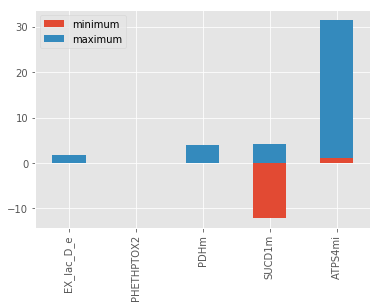

In [50]:
model = M.copy()

# a short list of reactions to calculate to reduce computational time. Feel free to adjust the list
# the reactions are: lactate uptake/production, phenylalanine hydroxylase 
# (which has an isoenzyme that performs a similar reaction), Pyruvate dehydrogenase, Succinate dehydrogenase 
# and ATPase
interesting_reactions = ['EX_lac_D_e','PHETHPTOX2','PDHm','SUCD1m','ATPS4mi',]

result = cobra.flux_analysis.flux_variability_analysis(model,reaction_list=interesting_reactions)
result[['minimum','maximum']]

result.plot.bar(stacked=True)

<span style="color:red">**Assignment (3 min):**</span> Which of these are reversible? i.e. they can carry flux in either forward or backward direction while the cell is still capable of optimal growth rate. 

# Are essential amino acids essential?
We will now look into which reactions the model predicts to be essential for growth. Are the "essential" amino acids predicted to be essential?

## Calculating the essential genes using flux variability analysis
One of the uses of FVA is to predict essential reactions. If we require growth to be non-zero then reactions that are essential will have an associated FVA interval that does not contain zero.

<span style="color:red">**Assignment (3 min):**</span> Make sure you understand the statement made above. Then look back at the plot above and figure out which of the reactions visualized there is essential? 

A helpful example is to think of glucuse exchange reaction. What would happen to this flux when the cell tries to grow optimally? Does this reaction need to carry flux? What does that say about the FVA interval? 

The cell below returns a table with essential reactions predicted by FVA. It might take a while to run...

In [51]:
model = M.copy()

# first perform pFBA to find a list of potentially essential reactions
# reasoning: if reaction v is essential it ALWAYS has to carry flux. So also in this pFBA solution. 
# doing this first allows us to perform FVA on a smaller set of reactions
sol = pfba(model)

# take only those reactions that carry flux
reactions_with_flux = sol.fluxes[sol.fluxes.abs() > 1e-9].index.tolist()

# perform fba on the flux carrying reactions
fva_sol = cobra.flux_analysis.flux_variability_analysis(model,reaction_list=reactions_with_flux,fraction_of_optimum=1)

# filter out 
fva_sol = fva_sol.loc[(fva_sol['minimum'] > 1e-9) | (fva_sol['maximum'] < -1e-9) ]
df = fva_sol.copy()
for r in df.index.tolist():
    df = df.set_value(r,'reaction',model.reactions.get_by_id(r).reaction)
    df = df.set_value(r,'genes',model.reactions.get_by_id(r).gene_reaction_rule)
df

/Users/thierry/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18 FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/thierry/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19 FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


,minimum,maximum,reaction,genes
3DSPHR,0.002953,3.701450,3dsphgn_c + h_c + nadph_c --> nadp_c + sphgn_c,2531.1
ADSL1,0.011283,27.598494,dcamp_c --> amp_c + fum_c,158.1 or 158.2
ADSL2,0.019055,0.029588,25aics_c --> aicar_c + fum_c,158.1 or 158.2
AIRCr,0.019055,0.029588,air_c + co2_c <=> 5aizc_c + h_c,10606.1
ARGSS,0.060674,13.854279,asp_L_c + atp_c + citr_L_c --> amp_c + argsuc_c + h_c + ppi_c,445.1 or 445.2
ASNS1,0.047191,9.242928,asp_L_c + atp_c + gln_L_c + h2o_c --> amp_c + asn_L_c + glu_L_c + h_c + ppi_c,440.1 or 440.3 or 440.2
ASPCTr,0.019424,3.930015,asp_L_c + cbp_c <=> cbasp_c + h_c + pi_c,790.1
DATPtn,0.002226,0.002226,datp_c <=> datp_n,
DGTPtn,0.001672,0.001672,dgtp_c <=> dgtp_n,
DHORD9,0.019424,3.930015,dhor_S_c + q10_m --> orot_c + q10h2_m,1723.1


<span style="color:red">**Assignment (2 min):**</span> Search to see if the glucose exchange reaction is in the table above. Is it essential? What is the FVA interval allowed under the condition of optimality? 

<span style="color:red">**Assignment (5 min):**</span> Rerun the cell above but change the 'fraction_of_optimum' parameter to less than 1. 1 means exactly optimal. 0.8 would mean you allow the solution to be at least 80% of the optimal growth rate. etc. What happens to the glucose exchange reaction interval when you decrease the 'fraction_of_optimum' parameter? Is there a point where it becomes non-essential?

# Self-check questions
Make sure you are able to explain in your own words: 
1. What the two core components of the human metabolic reconstruction model are
2. How thermodynamics of reactions may be taken into account in the reaction bounds
3. What flux balance analysis is
4. What FBA actually computates
6. How FVA is different from FBA 
7. What you can use FVA for